## Data preprocessing

In [82]:
import pandas as pd
#from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from pandas import Timestamp as ts


In [83]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
#data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)
#data.index.is_monotonic
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [85]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


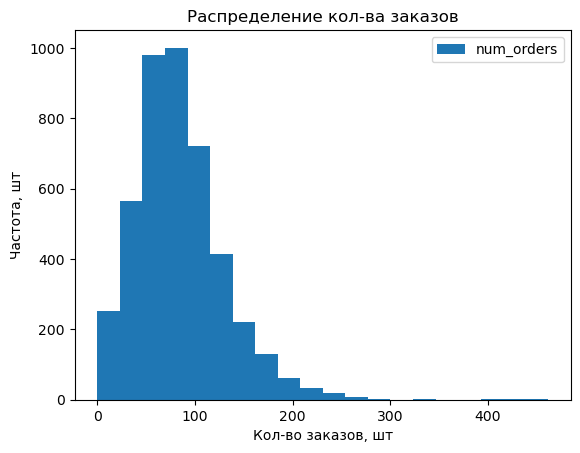

In [86]:
data.plot(kind='hist', bins=20, title='Распределение кол-ва заказов')
plt.xlabel('Кол-во заказов, шт')
plt.ylabel('Частота, шт')
plt.show()

In [2]:
# Seasonal decomposition

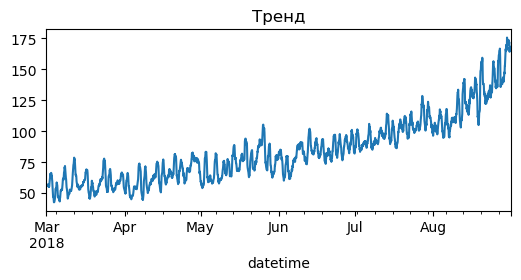

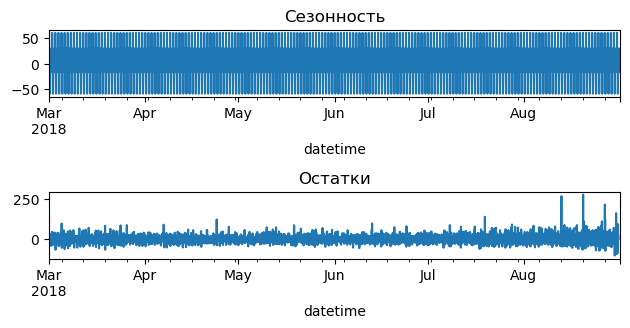

In [88]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.show()
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

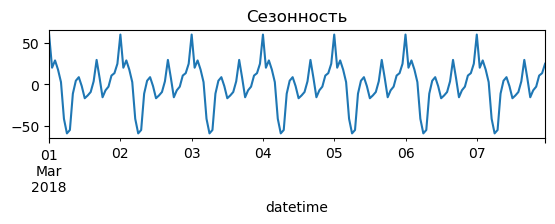

In [89]:
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

Over a longer time period, a positive trend is already visible.

## Train

In [90]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for i in range(1, max_lag + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data['day'], data['dayofweek'], data['hour'], data['lag_{}'.format(i)], data['rolling_mean']
    
#make_features(data, 1, 6)    
#data.head(10)    

In [91]:
make_features(data, 1, 24)    
data.head(10)    

,num_orders,day,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,NaN
2018-03-01 05:00:00,6,1,3,5,43.0,NaN
2018-03-01 06:00:00,12,1,3,6,6.0,NaN
2018-03-01 07:00:00,15,1,3,7,12.0,NaN
2018-03-01 08:00:00,34,1,3,8,15.0,NaN


In [92]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
features_train, features_test = train.drop('num_orders', axis=1), test.drop('num_orders', axis=1)
target_train, target_test = train['num_orders'], test['num_orders'] 
#train

In [11]:
#best_score = 49
#best_max_lag = 1
#best_rolling_mean_size = 1

#for i in tqdm(range(1, 101)):
#    for j in range(1, 101):
#        make_features(data, i, j)
#        train, test = train_test_split(data, shuffle=False, test_size=0.1)
#        train = train.dropna()
#        features_train, features_test = train.drop('num_orders', axis=1), test.drop('num_orders', axis=1)
#        target_train, target_test = train['num_orders'], test['num_orders'] 
#        model = LinearRegression()
#        model.fit(features_train, target_train)
#        rmse = mean_squared_error(target_train, model.predict(features_train)) ** 0.5
#        if rmse < best_score:
#            best_max_lag = i
#            best_rolling_mean_size = j
#print(best_max_lag, best_rolling_mean_size)

In [93]:
#period = [2018-03-01, 2018-03-02, 2018-03-03, 2018-03-04, 2018-03-05, 2018-03-06, 2018-03-07];
#data_daily = data.copy()
#data_daily['date'] = data_daily.index.date
#data_daily = data_daily.pivot_table(index='date', values='num_orders', aggfunc='sum')
#data_daily[(data_daily.index >= pd.to_datetime('2018-03-01')) & (data_daily.index <= pd.to_datetime('2018-03-07'))]
#for i in data_daily.index:
#    data_daily[data_daily.index == i].boxplot()
#    plt.show()


#data_daily['2018-03-01':'2018-03-07']
#for i in data_daily['date']:
#    data_daily.boxplot()
#    plt.show()

<b>Linear Regression</b>

In [94]:
model = LinearRegression()
model.fit(features_train, target_train)
rmse = mean_squared_error(target_train, model.predict(features_train)) ** 0.5
rmse

30.906838951032768

<b>Desicion Tree</b>

In [95]:
best_model = None
best_depth = 1
best_score = 1000

for depth in tqdm(range(1, 51)):
    model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    rmse = mean_squared_error(target_train, model.predict(features_train)) ** 0.5
    if rmse < best_score:
        best_model = model
        best_depth = depth
        best_score = rmse
print(best_score, best_depth)

100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 104.29it/s]

0.0 27


<s>Эту модель возьмем на тест, хотя у модели ДР значение метрики качества лучше, на тесте она выдает не самый лучший результат.</s>

<b>Random Forest</b>

In [96]:
best_model_rf = None
best_depth_rf = 1
best_score_rf = 1000
best_n = 1

for depth in tqdm(range(1, 51, 5)):
    for n in range(1, 101, 5):
        model = RandomForestRegressor(max_depth=depth, n_estimators=n, random_state=12345)
        model.fit(features_train, target_train)
        rmse = mean_squared_error(target_train, model.predict(features_train)) ** 0.5
        if rmse < best_score_rf:
            best_model_rf = model
            best_depth_rf = depth
            best_score_rf = rmse
            best_n = n
print(best_score_rf, best_depth_rf, best_n)

100%|███████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.43s/it]

8.698632660846005 31 96


## Test

Let's take the Random Forest model for the test, because its rmse value is the best of all.

In [97]:
mae_rf = mean_squared_error(target_test, best_model_rf.predict(features_test)) ** 0.5
mae_rf

46.99385500734709

The SL model on the test showed a value of RMSE = 47.7, which corresponds to our criterion < 48.

In [98]:
predicted_test = pd.Series(best_model_rf.predict(features_test), index=target_test)
predicted_test.index = target_test.index
#predicted_test = predicted_test.rename('predicted_num_orders')
predicted_test
#predicted_test.rename(columns={'num_orders': 'predicted_num_orders'})

datetime
2018-08-13 14:00:00     98.833333
2018-08-13 15:00:00    124.104167
2018-08-13 16:00:00    130.770833
2018-08-13 17:00:00    140.645833
2018-08-13 18:00:00     91.395833
                          ...    
2018-08-31 19:00:00     96.364583
2018-08-31 20:00:00    101.468750
2018-08-31 21:00:00    132.822917
2018-08-31 22:00:00    138.989583
2018-08-31 23:00:00    131.947917
Freq: H, Length: 442, dtype: float64

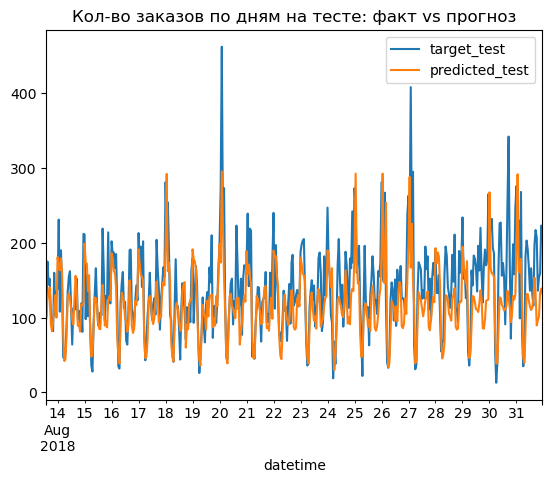

In [99]:
#pd.concat([target_test, predicted_test], axis=1)
ax = target_test.plot(label='target_test', legend=True)
predicted_test.plot(ax=ax, label='predicted_test', legend=True, title='Кол-во заказов по дням на тесте: факт vs прогноз')
plt.show()

If you look at the time interval = 1 day, you can see that the predicted values of the target feature have a slightly smaller spread than the actual values.

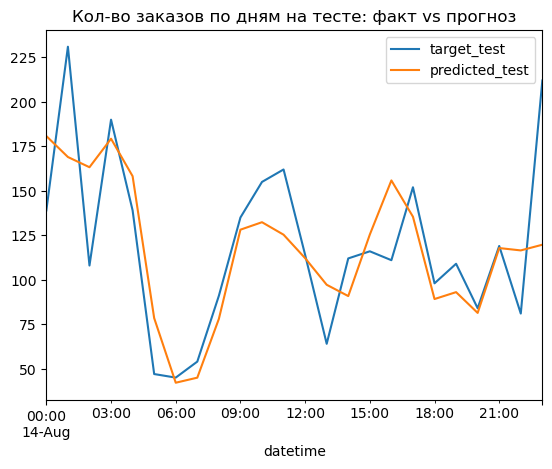

In [100]:
#pd.concat([target_test, predicted_test], axis=1)
ax = target_test['2018-08-14'].plot(label='target_test', legend=True)
predicted_test['2018-08-14'].plot(ax=ax, label='predicted_test', legend=True, title='Кол-во заказов по дням на тесте: факт vs прогноз')
plt.show()

Thus, using the Random Forest model with a forest depth of 26 and a number of trees of 96, we managed to obtain the value of the rmse = 48 metric, which satisfies our requests.

In [101]:
#rmse_test = mean_squared_error(target_test, model.predict(features_test)) ** 0.5
#rmse_test

In [102]:
#predicted_test = best_model.predict(features_test)

In [103]:
#rmse_test = mean_squared_error(target_test, predicted_test) ** 0.5
#rmse_test